# Step 3: Semi-empirical calibration of microphone probes

The empirical calibration data in step 1 demonstrated the issue of spurious resonance in empirical calibration. In step 2 an analytical calibration approach was presented, and the idea was pitched of combining the benefits from both of these calibration methods.

The presented approach uses (Metropolis-Hastings) Markov-chain Monte Carlo (McMC) to fit the model to the data. All the required steps are presented below.
1. Defining the empirical calibration data.
2. Setting up the analytical model.
3. Setting up the posterior probability density function (PDF) callable Python function, that can be called iteratively by the McMC function.
   * 3.1: Set up the prior PDF.
   * 3.2: Set up the likelihood PDF.
4. Run the McMC.

In [15]:
# Import required packages.
# - Plot figures inline with text in this notebook.
%matplotlib inline
# - Higher DPI figures.
%config InlineBackend.figure_format='retina'
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.stats as stats
import Source.BayesianInferenceFunctions as bi_f
import Source.BerghTijdemanWhitmoreModels as tt_m  # Analytical models.
from Source.ProcessingFunctions import frequency_response  # Complex TF to amplitude and phase of TF.
from Source.CalibrationMeasurement import PressureAcquisition
from Source.PlottingFunctions import plot_transfer_function_df

## 1. Read the calibration data.

Define the file paths, and the input and output column names for the data.
The use the object and methods presented in *Step1_loading_empirical_calibration_data.ipynb* to estimate the TF from the acquired calibration data.

In [16]:
# Data inputs.
FILE_PATH_FLUSH_CALIBRATION_STEP = os.path.join('..', 'TestData', 'BK_Pinhole', 'Flush_1.tdms')
INPUT_CHANNEL_FLUSH_CALIBRATION = [('Untitled', 'Channel 1')]
OUTPUT_CHANNEL_FLUSH_CALIBRATION = [('Untitled', 'Channel 2')]
FILE_PATH_MIC_CALIBRATION_STEP = os.path.join('..', 'TestData', 'BK_Pinhole', 'Pinhole_1.tdms')
INPUT_CHANNEL_MIC_CALIBRATION = [('Untitled', 'Channel 2')]
OUTPUT_CHANNEL_MIC_CALIBRATION = [('Untitled', 'Channel 1')]

# Data reading.
# True/False for 'safe' (but slower) reading of TDMS files. May be needed for partly corrupted data files.
SAVE_READING = False
obj_cal_flush_step = PressureAcquisition(file_path=FILE_PATH_FLUSH_CALIBRATION_STEP, fs=51200, safe_read=SAVE_READING)
df_cal_flush_tf = obj_cal_flush_step.transfer_function(
    in_channel=INPUT_CHANNEL_FLUSH_CALIBRATION, out_channel=OUTPUT_CHANNEL_FLUSH_CALIBRATION)
obj_cal_mic_step = PressureAcquisition(file_path=FILE_PATH_MIC_CALIBRATION_STEP, safe_read=SAVE_READING, fs=51200)
df_cal_mic_tf = obj_cal_mic_step.transfer_function(in_channel=INPUT_CHANNEL_MIC_CALIBRATION,
                                                   out_channel=OUTPUT_CHANNEL_MIC_CALIBRATION)
dct_linking_both_tf_column_names = dict(zip(df_cal_flush_tf.columns, df_cal_mic_tf.columns))
df_cal_both_tf = obj_cal_flush_step.add_transfer_function_step(
    df_tf_new=df_cal_mic_tf, dct_old_tf_to_new_tf_channels=dct_linking_both_tf_column_names)

A single TF is fitted in this case, so only column #0 is retained as a measurement (this is in case the input and output keys result in a *df_cal_both_tf* with multiple columns). This data is then split into the amplitude and phase of the TF, as fitting two real-valued arrays is more easy to understand than fitting a single complex-valued array.

The frequencies on which the TF data is defined is also saved as a frequency array (Hz and rad/s), as the model will need to estimate the TF at those very same frequencies.

In [17]:
# Data used for fitting.
measurement_df = df_cal_both_tf.iloc[:, [0]]  # Only take a single TF (first column).
measurement_df.columns = ['Data']
amp_d, phase_d = frequency_response(measurement_df.to_numpy(complex).flatten())  # Measurement amplitude and phase.

# Frequency array, used for the model fitting.
f_arr = df_cal_both_tf.index.to_numpy(float)
w_arr = 2*np.pi*f_arr

For now, the *F_MASK_LST* variable can be left as \[\[1E2, 8E3\]\]. This variable defines which frequencies of both amplitude and phase to band-pass for fitting: \[\[f_lower_0, f_upper_0\], ..., \[f_lower_i, f_upper_i\], ...\]. With \[\[1E2, 8E3\]\], all the data below 100 Hz and above 8 kHz are removed before fitting. Later on, one can band-remove other frequencies in the TF data to get an improved fit, e.g., by not having spurious resonance affect the fit. Setting this parameter is an iterative process. One can start with fitting all frequencies and see which frequency bands are not fit by the model, as this might indicate that this is spurious resonance.

In [18]:
F_MASK_LST = [[1E2, 8E3]]
# For example, you can try afterwards: F_MASK_LST = [[1E2, 2.3E3], [4.5E3, 8E3]].

masking_arr, f_masked_arr = bi_f.mask_f_data(frequency=f_arr, f_mask_arr=F_MASK_LST)
w_masked_arr = 2*np.pi*f_masked_arr
amp_d_masked, phase_d_masked = amp_d[masking_arr], phase_d[masking_arr]

## 2. Set up the analytical model.

Next up, the model and the initial guess are defined, so that both the empirical and analytical TF can be compared.

In [19]:
# Initial guess of the full model geometry.
LRV_PINHOLE = (2E-3, 0.25E-3, 10E-9)  # m, m, m^3
# Conditions used in model.
GAMMA, PR, C0, NU = 1.4, 0.7, 340.26, 1.46E-5

# Normalised geometrical parameters, but with the real valued norm of the shear wave number (constant).
norm_param = tt_m.dim_to_norm(*LRV_PINHOLE, c0=C0, nu=NU, alpha_complex=False)

For this example, the second and third **normalised** parameters are used for fitting, hence \[1:\] which removes the first element from *norm_param*.
For these fitting parameters, the constants of reduced frequency and shear wave number are used (as if $\omega=1$ rad/s), for the shear wave number, the norm of that constant is used.

In [20]:
INITIAL_GUESS = norm_param[1:]

Using the Whitmore model functions, one can define a function that can return the model TF with as input the fitting parameters.

In [21]:
def model(alpha_i, w=w_arr):
    el_pin = tt_m.Element(k_l_pre=norm_param[0], alpha_pre=alpha_i[0]*1j**1.5, vv_vt=alpha_i[1], gamma=GAMMA, pr=PR)
    pr_pin = el_pin(w=w)
    return frequency_response(pr_pin)

Having defined both the fitting data and model, both can be compared.

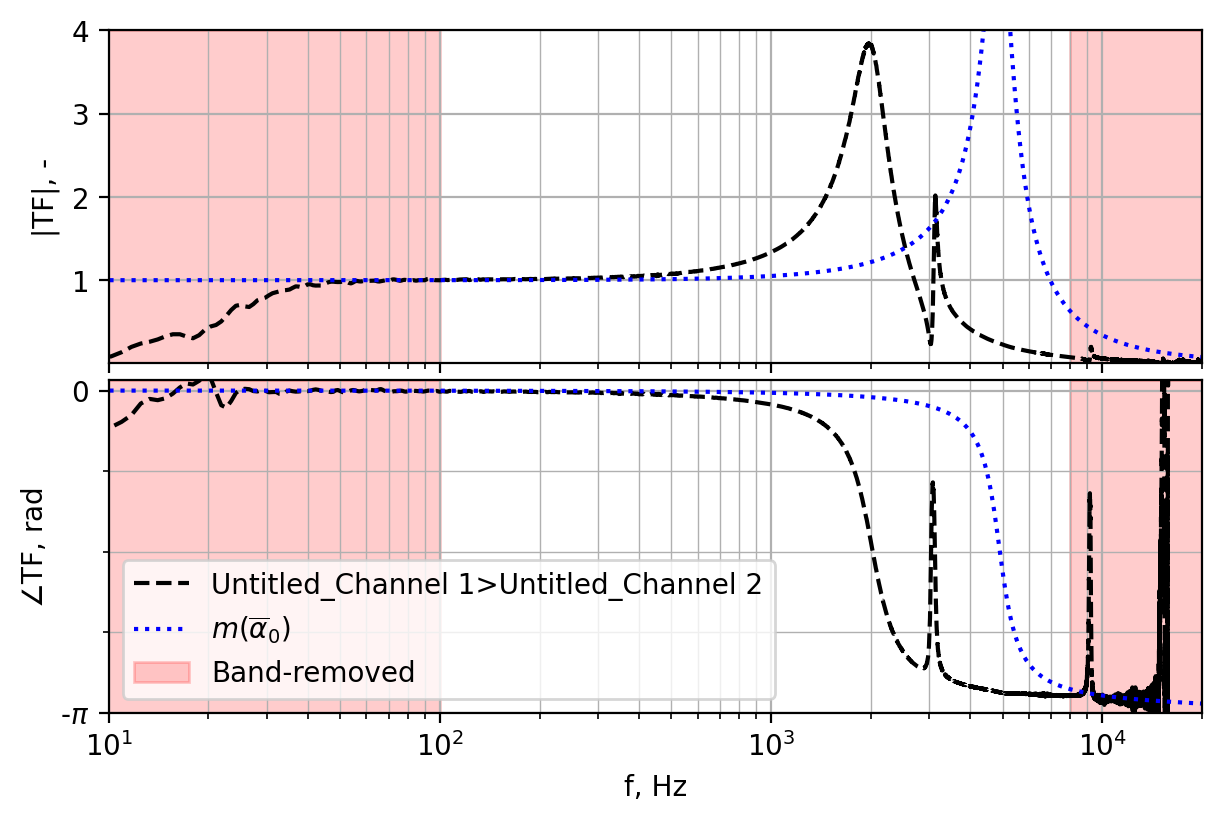

In [22]:
# Setting up the visualisation of band-removed frequencies. Need to convert from band-pass array to band-remove array.
f_min_range, f_max_range = 0, f_arr[-1]
f_mask_plotting = [[F_MASK_LST[i][-1], F_MASK_LST[i + 1][0]]
                   for i in range(len(F_MASK_LST) - 1)
                   if F_MASK_LST[i + 1][0] >= F_MASK_LST[i][-1]]
if len(f_mask_plotting) == 0:
    f_mask_plotting = [[f_min_range, F_MASK_LST[0][0]], [F_MASK_LST[-1][-1], f_max_range]]
else:
    f_mask_plotting = [[f_min_range, F_MASK_LST[0][0]]] + f_mask_plotting + [[F_MASK_LST[-1][-1], f_max_range]]

# Compute the TF of the initial guess.
amp_m_0, phase_m_0 = model(alpha_i=INITIAL_GUESS, w=w_arr)  # Initial guess model TF.

# Plot calibration data.
fig_tf, ax_tf = plot_transfer_function_df(
    df=df_cal_both_tf, fig_dim=(6, 4), alpha=1.0, linestyle='--', color='k', minor_phase=0.25,
    x_lim=(1E1, 2E4), y_lim_amp=(1E-2, 4E0), y_lim_phase=(-1*np.pi, 0.1))

# Plot the initial guess.
ax_tf[0].plot(f_arr, amp_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')
ax_tf[1].plot(f_arr, phase_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')

# Plot band-removed data.
for ax_i in ax_tf.flatten():
    y_lim_i = ax_i.get_ylim()
    for (x_lower_limit_i, x_upper_limit_i) in f_mask_plotting[:-1]:
        ax_i.fill_betweenx(y=y_lim_i, x1=2*[x_lower_limit_i], x2=2*[x_upper_limit_i],
                           color='r', alpha=0.2)
    ax_i.fill_betweenx(y=y_lim_i, x1=2*[f_mask_plotting[-1][0]], x2=2*[f_mask_plotting[-1][1]],
                       color='r', alpha=0.2, label='Band-removed')
ax_tf[-1].legend(loc='lower left')
fig_tf.tight_layout(pad=0.2)

The initial guess and data can differ, that is perfectly acceptable, as the fit will be improved using McMC. However, the similarities in both TFs are already clear: a single resonant frequency in both the amplitude and phase, which is what is expected from a pinhole. The resonance in 3 kHz and 9 kHz in the data are not present in any form in the model, as such one might already think of band-removing these elements to improve the fitting. It is best to fit the full (usable) frequency range at first.

## 3. Set up McMc.

McMC considers two information sources:
1. The mismatch between the model, at the proposed parameter values, and data. This is much the same as with most other fitting methods.
2. The probability of the proposed parameter values. As such, one can take into account how feasible the operator deems that the system has parameters of a certain value.

### 3.1 The prior PDF.

The probability of seeing those parameter values is summarised under the **prior** PDF. This PDF can be anything: a uniform PDF (which simply puts a bound on the extrema of the achievable parameter values), a Gaussian (used here), something else, or even a combination of multiple PDFs. For the sake of this method, the prior PDF does not even need to integrate to unity. The prior contains the *prior* knowledge of the operator on the considered problem. With iteratively applying McMC, this prior knowledge, and hence the defined prior PDF, can change based on the updated knowledge of the operator.

A Gaussian is a good fit for these parameters; measuring the tube-length multiple times, one achieves a mean measurement with some variance, or one measures a single time with the measurement uncertainty linked to the measurement device.

Either way, a mean and standard deviation needs to be defined for every parameter in the parameter vector. A logical mean for the prior is the initial guess.
Scipy.stats provides several functions for statistics, e.g., *stats.norm*. This very same function is implemented in *Source.BayesianInferenceFunctions.PriorArray*. Either way, this object can be called later in the posterior at the new proposed parameter value.

In [23]:
PRIOR_MU = INITIAL_GUESS  # Mean.
# Once again, only use the second (index 1) and third (index 2) parameter for fitting.
PRIOR_SD = [1.5E-6, 1.8E-2, 6.4E1][1:]  # Standard deviation.

# prior_obj = Source.BayesianInferenceFunctions.PriorArray()
# And then call: prior_obj.log_pdf()
prior_obj = stats.norm(loc=PRIOR_MU, scale=PRIOR_SD)

### 3.2 The likelihood PDF.

The aforementioned mismatch between data and model is taken into account by the likelihood PDF. This formulation assumes that the measurement data $d$ comes from the *true* model state $u$, that is sampled at certain frequencies. That sampling is performed by measuring the system state, which introduces a measurement error $\varepsilon$. The measurement error is assumed to be Gaussian, centered on zero. In case the data and state are not available at the same frequencies, or for example the measurements are the derivative of the state, the matrix $H$ can be used to adapt $u$ to be at the same locations as $d$ and the same type of (derived) quantity. In this case, the very same frequencies are fed to the model, as such one can ignore $H$ or define it as the identity matrix.

$$ d = H \circ u + \varepsilon \quad \text{with} \ \ \varepsilon \sim \mathscr{N}(\overline{0}, \overline{\sigma}_d)$$

Or in other words:
$$ \rho(d|u) = \varepsilon = d - H \circ u \sim \mathscr{N}(\overline{0}, \overline{\sigma}_d) $$

The model $m$ provides an errorless state $u$, given the considered parameter (vector) $\overline{\alpha}$: $$u = m(\overline{\alpha})$$

In this case, the data contains both amplitude and phase. They are related with each other through the physics of this problem. However, for simplicity's sake the likelihood of both of these quantities is defined separately, and can be tuned with separate measurement error standard deviations (to favour the fit of either amplitude or phase).

Do note that the likelihood (and the prior) used here are log PDFs. This helps with a lot of fitting problems, where it is expected that only a narrow range of parameter values results in a good fit (hence high likelihood). Therefore, the PDF used for fitting will have a very high value in a small range of parameters, and a very low value around it. Using a logarithmic PDF, the comparison of a very small PDF value with another very small PDF value can be a bit more accurate. This will also help deal with the large range of PDF values.

In [24]:
SIG_D_AMP = 0.5  # Measurement error standard deviation of TF amplitude. Used in likelihood PDF.
SIG_D_PHASE = 0.2  # Measurement error standard deviation of TF phase. Used in likelihood PDF.


# Implemented in: Source.BayesianInferenceFunctions.likelihood_log_pdf()
def likelihood_log_pdf(u, d, sigma_d):
    """
    Likelihood of model state with data, given measurement variance.

    :param u: Model state vector.
    :param d: Measurement vector.
    :param sigma_d: Measurement variance.

    :return: Value of log likelihood PDF.
    """
    d_hu = d - u
    log_rho = float(np.sum(stats.norm.logpdf(x=d_hu, scale=sigma_d)))
    return log_rho

### 3.3 The posterior PDF.

McMC combines both the prior and likelihood, i.e., probability of parameter values (operator knowledge) and data misfit. The combination of both PDFs is called the posterior PDF. As mentioned above a logarithmic prior and likelihood are used, hence a logarithmic posterior, which is the **sum** of the prior and likelihood.

$$ \rho(\overline{\alpha}|d) \sim \rho(\overline{\alpha}|d) \rho_0(\overline{\alpha}) $$

In [25]:
def posterior(alpha_i):
    # ! Only consider masked frequencies, masked amplitude, and masked phase.
    # Compute the Prior PDF at the proposed parameter values.
    prior_log_pdf = float(np.sum(prior_obj.logpdf(x=alpha_i)))
    # Evaluate the model at the proposed parameter values.
    amp_u, phase_u = model(alpha_i=alpha_i, w=w_masked_arr)
    # Likelihood PDF for:
    like_amp_log_pdf = likelihood_log_pdf(u=amp_u, d=amp_d_masked, sigma_d=SIG_D_AMP)  # TF amplitude.
    like_phase_log_pdf = likelihood_log_pdf(u=phase_u, d=phase_d_masked, sigma_d=SIG_D_PHASE)  # TF phase.
    return prior_log_pdf + like_amp_log_pdf + like_phase_log_pdf

# 4. Running the McMC.

With all the setup performed. The McMC can be run, once the last couple of parameters are defined: how many samples are taken, the seed of the McMC (for reproducibility of results in academic uses), the standard deviation in each parameter axis used by the sampling Gaussian $\mathscr{G}$.

Running the McMC can take quite some time, depending on the computational cost of the model and the number of samples. This especially takes a long time on the Jupyter notebook. Enough samples are desired to have the method converge to a solution. The sampling Gaussian standard deviation defines the step sizes between the samples. Large step sizes have a larger probability of being rejected, smaller steps have a higher correlation to the previous step. The sampling Gaussian needs to be tuned to balance both of these issues, ideally an acceptance rate around 30\% is achieved. The first samples can have a higher acceptance ratio while the chain is still converging from the low probability region to the high probability region around the best fit, this is called *'burn-in'* of the chain.
A deeper dive into the Metropolis-Hastings McMC algorithm is provided in the *Extra_basics_bayesian_inference.ipynb* notebook (**Work in progress**).

The results of the McMC are saved in ./Media/McMC_results.pickle, which will be processed in more detail in the next notebook *Step4_processing_results_semi_empirical_calibration.ipynb*.

In [12]:
N_SAMPLES = 5000  # Total number of samples in McMC. Includes rejected samples.
# Standard deviation of Gaussian used for sampling of McMC. Considers normalised parameters.
G_SD = np.array([4.5E-9, 1E-3, 1.92E-1])[1:] * 1E0

SEED = 3751  # Seed used for Gaussian sampling distribution and Uniform sieve in McMC.

# Run McMC.
alpha_chain, rho_chain, dct_seed = bi_f.mcmc_update(
    n_params=len(INITIAL_GUESS), posterior_log_pdf=posterior,
    alpha_0=INITIAL_GUESS, n_samples=N_SAMPLES, seed=SEED,
    sigma_p=G_SD, n_updates=N_SAMPLES//10)

# Save the fitting results to process later.
# - Make dictionaries to write to output file for McMC.
dct_conditions = {'C0': C0, 'NU': NU, 'GAMMA': GAMMA, 'PR': PR}
dct_mcmc = {'F_BAND_REMOVE_LST': f_mask_plotting, 'ALPHA_SD': PRIOR_SD, 'G_SD': G_SD, 'SIG_D_AMP': SIG_D_AMP,
            'NOTES': '', 'SIG_D_PHASE': SIG_D_PHASE, 'N_SAMPLES': N_SAMPLES,
            'LRV': LRV_PINHOLE, 'SEED': dct_seed, 'PAR_STR': ['alpha', 'vv_vt'],
            'ALPHA_FULL': norm_param}
dct_out = {'DATA': measurement_df, 'CONDITIONS': dct_conditions, 'MCMC_SETTINGS': dct_mcmc,
           'alpha_chain': alpha_chain, 'rho_chain': rho_chain}

# - Write output file to pickle file. Can be loaded by McMC processing code:
#       Don't want to run McMC again each time you want to process the McMC results.
with open(os.path.join('.', 'Media', 'McMC_results.pickle'), 'wb') as handle:
    pickle.dump(dct_out, handle, protocol=pickle.HIGHEST_PROTOCOL)

(1/10) Acceptance Ratio: 44.69%
(2/10) Acceptance Ratio: 39.88%
(3/10) Acceptance Ratio: 44.69%
(4/10) Acceptance Ratio: 30.46%
(5/10) Acceptance Ratio: 25.05%
(6/10) Acceptance Ratio: 26.85%
(7/10) Acceptance Ratio: 28.06%
(8/10) Acceptance Ratio: 29.86%
(9/10) Acceptance Ratio: 28.06%
Acceptance Ratio: 32.15%


The results of the McMC can be plotted below. Given the limited number of samples etc. the fit can still be imperfect, e.g., the strength of the resonance (viscosity, hence shear wave number) might be wrong. If one want to play around more, it is advised that one uses the main code in *SemiEmpiricalCalibrationBayesian/BK_Pinhole_McMC.py*, as this code is not a Jupyter notebook and will hence run faster.

In [26]:
# For plotting: Best fitting parameters (MAP: Maximum A Posteriori).
alpha_map = alpha_chain[np.argmax(rho_chain), :]  # Parameter array.
amp_m_map, phase_m_map = model(alpha_i=alpha_map, w=w_arr)  # Amplitude and phase of TF.

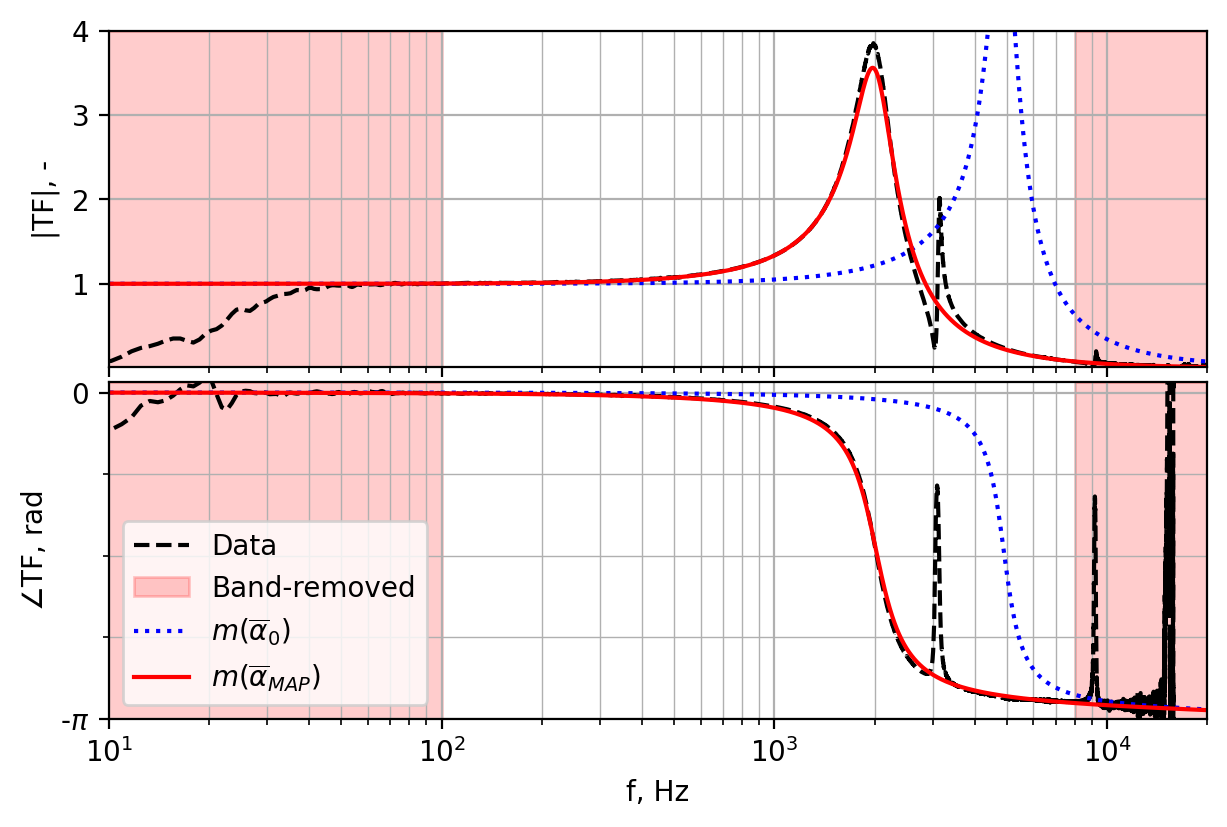

In [27]:
fig_tf, ax_tf = plot_transfer_function_df(
    df=measurement_df, fig_dim=(6, 4), color='k', linestyle='--', alpha=1., legend_loc='lower left',
    minor_phase=0.25, x_lim=(1E1, 2E4), y_lim_amp=(1E-2, 4E0), y_lim_phase=(-1*np.pi, 0.1))
# Plot band-removed data.
for ax_i in ax_tf.flatten():
    y_lim_i = ax_i.get_ylim()
    for (x_lower_limit_i, x_upper_limit_i) in f_mask_plotting[:-1]:
        ax_i.fill_betweenx(y=y_lim_i, x1=2*[x_lower_limit_i], x2=2*[x_upper_limit_i],
                           color='r', alpha=0.2)
    ax_i.fill_betweenx(y=y_lim_i, x1=2*[f_mask_plotting[-1][0]], x2=2*[f_mask_plotting[-1][1]],
                       color='r', alpha=0.2, label='Band-removed')

ax_tf[0].plot(f_arr, amp_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')  # Initial guess.
ax_tf[1].plot(f_arr, phase_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')
ax_tf[0].plot(f_arr, amp_m_map, color='r', linestyle='-', label=r'$m(\overline{\alpha}_{MAP})$')  # Best guess.
ax_tf[1].plot(f_arr, phase_m_map, color='r', linestyle='-', label=r'$m(\overline{\alpha}_{MAP})$')
ax_tf[1].legend(loc='lower left')
fig_tf.tight_layout(pad=0.1)  # Tries to fill white-space in figure.

Further processing of these McMC results is performed in the next notebook *Step4_processing_results_semi_empirical_calibration.ipynb*.